### Libraries

In [499]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import ndimage

import shapely.geometry as geom
import pandas as pd
import geopandas as gpd

import math
import time
import pickle
from collections import namedtuple


%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)

## Load from disk

In [500]:
poses = pickle.load(open("poses.df", 'rb'))
arena_d = pickle.load(open("arena_d.df", 'rb'))
arena_g = pickle.load(open("arena_g.gdf", 'rb'))

# Convert Pandas DataFrame to NumPy array
poses_np = np.array(poses.values)

## Variables

In [501]:
Measurement = namedtuple('Measurement', ['sonar', 'IR_L', 'IR_R'])
Pose = namedtuple("Pose", ['x', 'y', 'theta'])

## Parameters

In [502]:
poses_np[:,7]

array([ 0.00029138,  0.00029138,  0.00029138, ...,  0.        ,
        0.        ,  0.        ])

## Generate NumPy array

## Playground: testing space

### Arena

In [503]:
# mock_position = geom.Point(0.01, 0.81)
# # theta = geom.Point(0, 6)
# # mock_circle = geom.Point(0,0).buffer(6, resolution=30)

# # scan = geom.LineString((mock_position, theta))
# # arena_d.loc[len(arena_d)] = ["scan", scan]

# arena_d.loc[len(arena_d)] = ['test', mock_position]
# arena_g = gpd.GeoDataFrame(arena_d)
# arena_g.plot()


# # cleat the dataframe
# arena_d.drop(arena_d.index[arena_d['type'] == 'test'], inplace=True)
# print(arena_g)

### Probability

In [504]:
# sigma = 0.05
# mean = 0.5

# sigma = 1/sigma

# x = np.linspace(0,1,500) # 100 linearly spaced numbers
# y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))

# a = 0.55
# b = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((a - mean))**2))

# plt.plot(x,y)
# plt.plot(a,b,'co')

## Grid Localization

In [505]:
def _match(sensor, reading, lookup_value):
    """
    Determines if a reading from the sensors matches a value 
    in the lookup table with some probability.
    
    """
    THRESHOLD = 0.6 
    if reading == None and lookup_value == None:
        return True
    elif sensor == "sonar":
        SIGMA = 0.1
    elif sensor == "IR_L":
        SIGMA = 0.1
    elif sensor == "IR_R":
        SIGMA = 0.1

    sigma = 1/SIGMA
    mean = lookup_value
    x = reading
    y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))
    if y > THRESHOLD:
        return True
    return False
    
def localize(poses_np, measurement):
    """
    poses_np    :: a lookup table of possible poses and sensor readings. Columns: open, x, y, theta, sonar, IR_L, IR_R
    measurement :: a tuple of readings from (sonar, IR_L, IR_R).
    
    """
    THRESHOLD = 0.8
    def posterior():
        """
        Finds posterior = [prior] X [probability after measurement]
        """
        
        # DEBUGGING VARIABLES
        count = {
            'sonar': 0,
            'IR_L': 0,
            'IR_R': 0,
            'all': 0,
        }
        
        # CRITICAL VARIABLES – 
        # CHANGE ONLY IF YOU KNOW WHAT YOU'RE DOING
        prob_sum = 0
        
        for i in range(len(poses_np)): # iterate rows
            if poses_np[i][0] == 1: # of open space, i.e. not coordinates of an obstacle
                match_all = False
#                 print(str(measurement.IR_R) + " " +  str(poses_np[i][6]))
                if _match('sonar',  measurement.sonar,  poses_np[i][4]):
                    count['sonar'] += 1
                    match_all = True
                    if _match('IR_L',  measurement.IR_L,  poses_np[i][5]):
                        count['IR_L'] += 1
                        if _match('IR_R',  measurement.IR_R,  poses_np[i][6]):
                            count['IR_R'] += 1
                            
                            
                poses_np[i][7] = (poses_np[i][7] * (match_all * THRESHOLD + (1-match_all) * (1.0-THRESHOLD)))
                prob_sum += poses_np[i][7]

        print(count)
        # normalize--> total probability theory
        for i in range(len(poses_np)):
            poses_np[i][7] = poses_np[i][7] / prob_sum
    
    posterior()
    return poses_np

## Heatmap

In [506]:
def heatmap(poses_np):
    """
    The heatmap relies on the following sorting of the array:
    'y' descending (primary sort)
    'x' ascending (secondary sort)
    'theta' ascending (tertiary sort)
    
    """
    
    plt.rcParams["figure.figsize"] = (10,5)
    heatmap = []
    y = poses_np[0][2]
    row = []
                
    # iterate through lookup table
    for i in range(len(poses_np)): 
        # True while we're moving horizontally to the right – x increases, y stays constant
        if y == poses_np[i][2]:
            if poses_np[i][3] == 0:  # if theta == 0
                row.append(poses_np[i][7]) # append probability
            else:
            # theta is some rotation, we're at same square still
                row[-1] += poses_np[i][7] # saturate probability here 
        # y changes – we're one row lower
        else:
            heatmap.append(row)
            row = []
            y = poses_np[i][2]
            row.append(poses_np[i][7])

    # Make plot with vertical (default) colorbar
    fig, ax = plt.subplots()

    cax = ax.imshow(heatmap, interpolation='nearest', cmap=cm.coolwarm)
    ax.set_title('Probabalistic location')

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
    
    plt.show()

# Run

In [507]:
def refresh(poses_np):
    """ 
    Takes all rows where 0-indexed column 1 one,
    and change 7-indexed column to the prior probability.
    
    """
    prob = 1.0 / len(poses_np[:,0])
    poses_np[poses_np[:, 0] == 1, 7] = prob
    return poses_np

def run(measurements, poses_np):
    for measurement in measurements:
        poses_np = localize(poses_np, measurement) 
        heatmap(poses_np)
    return poses_np

In [508]:

# measurements = [Measurement(0.1900000, 0.012310000, 3.98), 
#                 Measurement(0.6219393, 0.11132547, 1.200889), 
#                 Measurement(0.380000, 0.020000, 2.250448)]

{'sonar': 364, 'IR_L': 63, 'IR_R': 2, 'all': 0}


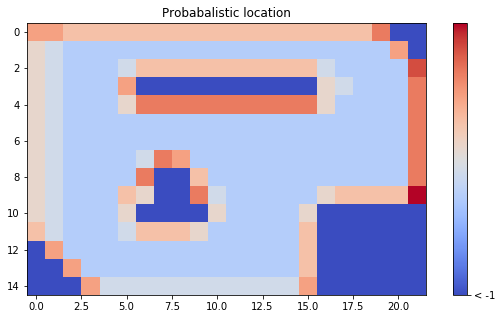

In [509]:
measurements = [Measurement(0.12, 0.012310000, 3.98)]

# refresh
poses_np = refresh(poses_np)
# # show prior
# heatmap(poses_np)
# GO!
poses_np = run(measurements, poses_np)

In [498]:
# poses_np[:,7]